### 1.2  Power spectrum estimation

In [158]:
using Distributions
using FFTW
using DSP
using Plots
using Random

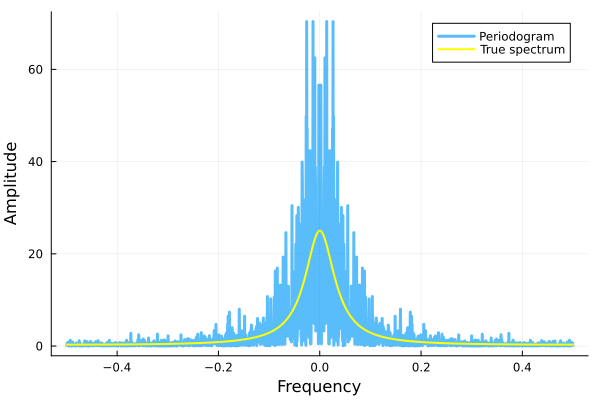

In [159]:
N = 2000
a = -0.8

f = LinRange(-0.5, 0.5, N)

μ, σ = 0.0, 1.0  # Mean and standard deviation of the normal distribution
𝑁 = Normal(μ, σ)
x = rand(𝑁, N)
y = filt([1], [1, a], x)
Yf = fft(y)
Py = 1 / N * abs2.(Yf)
plot(f, fftshift(Py) # fftshift is used to center the zero frequency component
    , alpha=0.65
    , label = "Periodogram"
    , xlabel = "Frequency", ylabel = "Amplitude"
    , legend = :topright
    , linewidth = 3
)

h = [1, a] # Create an impulse response and manually zero-pad to length N
h_padded = vcat(h, zeros(N - length(h)))
H = fft(h_padded) # Take FFT of the zero-padded impulse response
Sy = abs.(1 ./ abs.(H).^2) # Calculate the true spectrum
plot!(f, fftshift(Sy)
    , color="yellow"
    , linewidth = 2
    , label="True spectrum"
)

The provided source code calculates and plots the true power spectrum of a signal. Here's a breakdown of what it does:

1. `N = 2000`: Defines the number of data points in the signal.

2. `a = -0.8`: Specifies a filter coefficient. This coefficient represents a filter with a single pole at `a` when used in the context of signal filtering.

3. `fft([1, a], N)`: Computes the Fast Fourier Transform (FFT) of a filter represented by the coefficients `[1, a]`. This effectively calculates the frequency response of the filter.

4. `abs(1 / abs(...)**2)`: This part of the code computes the power spectrum of the filter. Here's how it works:
   - `abs(...)` calculates the magnitude of each element in the frequency response.
   - `1 / abs(...)**2` takes the reciprocal of the square of the magnitude of each element, effectively calculating the power spectrum.

5. `plt.plot(f, fftshift(Sy), color="yellow", lw=2, label="True spectrum")`: This line plots the true spectrum:
   - `f`: Represents the frequency values corresponding to the FFT result.
   - `fftshift(Sy)`: Rearranges the power spectrum values so that the zero frequency component is in the center of the plot (useful for visualization).
   - `color="yellow"`: Specifies the color of the plotted line.
   - `lw=2`: Sets the line width of the plot.
   - `label="True spectrum"`: Adds a label to the plot for reference.

In summary, this code computes the true power spectrum of a filter specified by the coefficient `a` and plots it against the corresponding frequencies. The power spectrum represents the distribution of signal power across different frequency components, providing insights into the frequency characteristics of the filter.

In [160]:
# Assuming Py is already defined from previous operations
Ry = ifft(Py);

# Create a Hamming window with 200 points
# In Julia, the Hamming window function in the DSP package does not have a 'sym' parameter
# The function by default creates symmetric windows, which is equivalent to 'sym=True' in Python's scipy.signal.hamming
# hh = hamming(200);

In [161]:
using DSP.Windows
using StatsBase

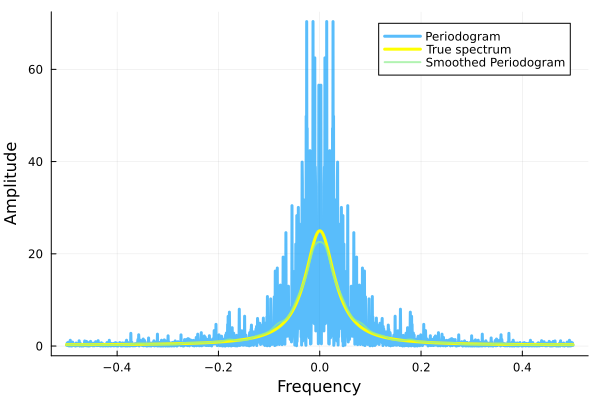

In [162]:
L = 100

# Define the Hann window using DSP.Windows.hanning
h = hanning(L)

# Shift the Hann window using FFTW's fftshift
h = fftshift(h)

z = zeros(N)
z[1:div(L, 2)] .= h[1:div(L, 2)]
z[end:-1:end-div(L, 2)+1] .= h[end:-1:end-div(L, 2)+1]

# Perform FFT on z multiplied by Ry (assuming Ry is defined)
Py_smoothed = abs.(fft(z .* Ry))

plot(f, fftshift(Py) # fftshift is used to center the zero frequency component
    , alpha=0.65
    , label = "Periodogram"
    , xlabel = "Frequency", ylabel = "Amplitude"
    , legend = :topright
    , linewidth = 3
)
plot!(f, fftshift(Sy)
    , color="yellow"
    , linewidth = 3
    , label="True spectrum"
)
plot!(f, fftshift(Py_smoothed)
    , alpha=0.7
    , color="lightgreen"
    , linewidth = 2
    , label="Smoothed Periodogram"
)

In [163]:
function averaged_perio(y, M)
    N = length(y)
    L = Int(round(N / M))
    Py_averaged = zeros(Complex{Float64}, N)
        
    for m in 0:M-1
        low = (m * L + 1)
        up = (m + 1) * L
        y_trunk = y[low:up]
        y_padded = vcat(y_trunk, zeros(N - length(y_trunk)))
        y_f = fft(y_padded)# ; @show low, up, length(y_trunk), N
        Py_averaged .+= (1 / L) .* abs2.(y_f)
    end
    
    return Py_averaged / M
end

averaged_perio (generic function with 1 method)

In [164]:
# Assuming y is defined elsewhere
Py_averaged = averaged_perio(y, 20);

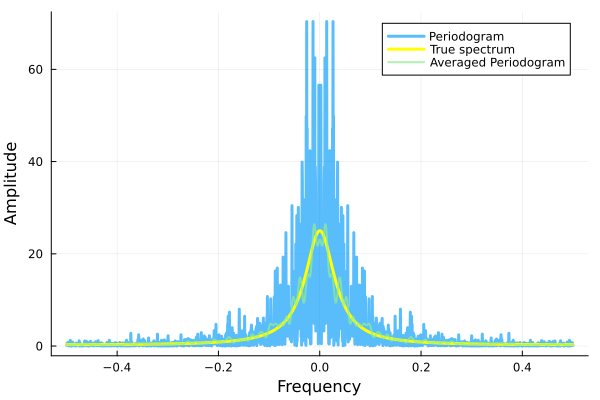

In [165]:
plot(f, fftshift(Py) # fftshift is used to center the zero frequency component
    , alpha=0.65
    , label = "Periodogram"
    , xlabel = "Frequency", ylabel = "Amplitude"
    , legend = :topright
    , linewidth = 3
)
plot!(f, fftshift(Sy)
    , color="yellow"
    , linewidth = 3
    , label="True spectrum"
)
plot!(f, fftshift(abs.(Py_averaged))
    , alpha=0.7
    , color="lightgreen"
    , linewidth = 2
    , label="Averaged Periodogram"
)

### 2.1  Matched filter

In [166]:
using Plots; gr()
using DSP

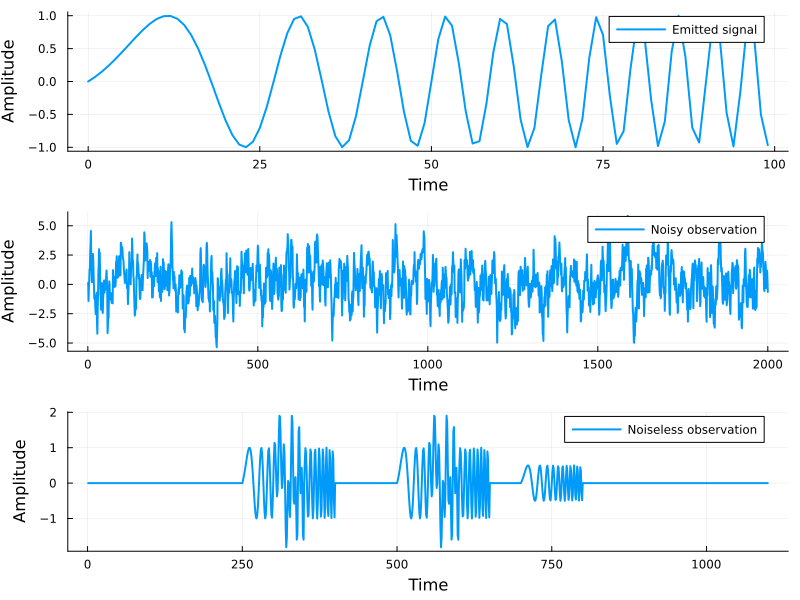

In [167]:
N = 1000

# Interface detection by cross-correlation
t = 0:99
A = 0.5
s = 1.0 .* sin.(2 * π .* 0.01 .* (1.0 .+ 0.1 .* t) .* t)  # Emitted signal
pl1 = plot(t, s, label="Emitted signal", xlabel="Time", ylabel="Amplitude", legend=:topright)

# List of interfaces
pos = [250, 300, 500, 550, 700]
amp = [1.0, 1.0, 1.0, 1.0, 0.5]
g = zeros(N)
g[pos] .= amp

# Add noise
A = 0.1
z = y .+ A .* randn(size(y))
pl2 = plot(z, label="Noisy observation", xlabel="Time", ylabel="Amplitude", legend=true)

# Convolution to generate the noiseless observation
y = conv(s, g)
pl3 = plot(y, label="Noiseless observation", xlabel="Time", ylabel="Amplitude", legend=true)

plot(pl1,pl2,pl3
    , layout = (3,1)
    , linewidth = 2
    , size = (800,600)
)

In [168]:
function zeropad(v, N)
    a = zeros(eltype(v), N)
    a[1:length(v)] .= v
    return a
end

zeropad (generic function with 1 method)

In [169]:
# Padding is not needed since DSP.xcorr does the padding by default, padmode = :none
sp = zeropad(s, length(z)); 

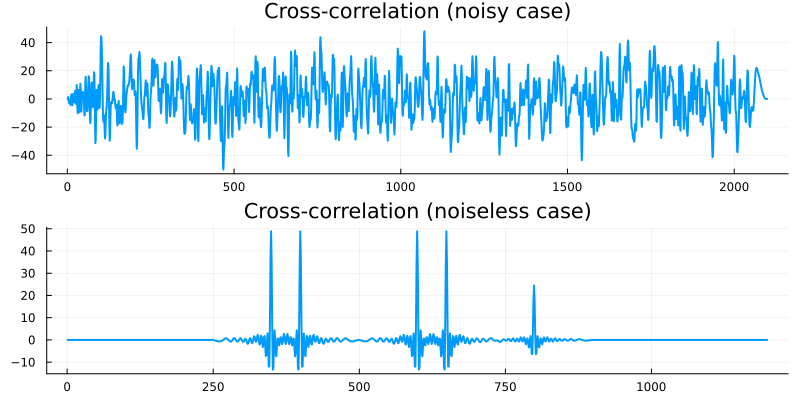

In [170]:
# Cross-correlation (noisy case)
Rzs = xcorr(z, s, padmode = :none)
pl1 = plot(Rzs, title="Cross-correlation (noisy case)")
# Cross-correlation (noiseless case)
Rys = xcorr(y, s, padmode = :none)
pl2 = plot(Rys, title="Cross-correlation (noiseless case)")
plot(pl1,pl2
    , layout = (2,1)
    , linewidth = 2
    , legend = :none
    , size = (800,400)
)

In [140]:
using StatsBase

alpha = 0.999
loc = 0
scale = 1

interv = quantile(Normal(loc, scale), [(1 - alpha) / 2, 1 - (1 - alpha) / 2])
println(interv)


[-3.290526731491899, 3.290526731491931]


In [141]:
LR = length(Rzs)
Rzs_th = zeros(LR)
intervs = interv * std(Rzs[500:end])  # Adjusted for Julia indexing

Rzs_th .= [
    (Rzs[u] < intervs[1] || Rzs[u] > intervs[2]) ? Rzs[u] : 0
    for u in 1:LR
]

# fig, ax = subplots(1, 1, figsize=(8, 3))
plot(1:LR,Rzs_th)

println("The position of interfaces are at", findall(x -> x != 0, Rzs_th) .+ lags[1])
intervs

The position of interfaces are at[348.0, 349.0, 350.0, 398.0, 399.0, 400.0, 598.0, 599.0, 600.0, 648.0, 649.0, 650.0, 798.0, 799.0, 800.0]


2-element Vector{Float64}:
 -14.716450813906512
  14.716450813906654

# References
- [ ] [Matched Filter](https://perso.esiee.fr/~bercherj/Lectures_SignalProcessing/Lecture3_RandomSignals.html#Matched-filter)